In [1]:
import numpy as np
import re
from skimage import io
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
from tqdm import tqdm
from matplotlib.legend_handler import HandlerTuple
import pickle
from monai.utils import (
    first, 
    set_determinism, 
    ensure_tuple
)
from monai.transforms import (
    AsDiscrete,
    AsDiscreted,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    RandAffined,
    RandRotate90d,
    RandShiftIntensityd,
    RandFlipd,
    RandGaussianNoised,
    RandAdjustContrastd,
    ScaleIntensityRanged,
    Spacingd,
    EnsureTyped,
    EnsureType,
    Invertd,
    AddChanneld,
    RandGaussianSharpend,
    RandGaussianSmoothd,
    RandHistogramShiftd,
    OneOf,
    Rand3DElasticd,
    Rand3DElastic,
    RandGridDistortiond,
    RandSpatialCropSamplesd,
    FillHoles,
    LabelFilter,
    LabelToContour,
    RandCoarseDropoutd
    
)
from monai.handlers.utils import from_engine
from monai.networks.nets import UNETR
from monai.networks.layers import Norm
from monai.metrics import (
    DiceMetric, 
    HausdorffDistanceMetric
)
from monai.losses import (
    DiceLoss, 
    DiceCELoss, 
    DiceFocalLoss
)
from monai.losses import DiceLoss, DiceCELoss, DiceFocalLoss, FocalLoss, TverskyLoss, ContrastiveLoss
from monai.inferers import sliding_window_inference
from monai.data import (
    CacheDataset, 
    DataLoader, 
    Dataset, 
    decollate_batch, 
    ImageReader
)
from monai.data.image_reader import WSIReader
from monai.config import (
    print_config, 
    KeysCollection, 
    PathLike
)
from monai.apps import download_and_extract
import torch
from torchio.transforms import (
    RandomAffine
)
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
import glob
from numpy import random
from pathlib import Path
import re
from skimage import io
from typing import (
    Optional, 
    Union, 
    Sequence, 
    Callable, 
    Dict, 
    List
)
#from monai.data.utils import is_supported_format
#from monai. data.image_reader import (
#    _copy_compatible_dict, 
#    _stack_images
#)
from nibabel.nifti1 import Nifti1Image
from PIL import Image
import numpy as np
from tqdm import tqdm
import pickle
import pandas as pd
#from mlflow import log_metric, log_param, log_artifacts, set_experiment, start_run, end_run
import warnings
warnings.filterwarnings('ignore')
from torchviz import make_dot

In [2]:
dirc = Path('training_models/')
folders = list(dirc.glob('*/metrics_validation_rerun.xlsx'))
folders = sorted([x.as_posix() for x in folders])
file = folders[2]
print(file)

training_models/436/metrics_validation_rerun.xlsx


In [3]:
metrics = pd.read_excel(file)

In [4]:
metrics

,Unnamed: 0,Val_Mean_Dice,test_Mean_Dice,boundary_detection_dice,boundary_detection_dice_test,boundary_difference_dice,boundary_difference_dice_test
0,0,0.060866,0.049308,0.169935,0.151415,0.902369,0.913377
1,1,0.083653,0.070942,0.146984,0.149074,0.909967,0.907884
2,2,0.109461,0.094838,0.148729,0.139993,0.905022,0.906143
3,3,0.138054,0.119836,0.150313,0.133482,0.901739,0.913726
4,4,0.168917,0.144837,0.138817,0.169108,0.914040,0.880686
...,...,...,...,...,...,...,...
1195,1195,0.749600,0.743533,0.277142,0.261017,0.916989,0.926492
1196,1196,0.758866,0.755902,0.262445,0.252673,0.932798,0.936688
1197,1197,0.776585,0.763340,0.264518,0.244814,0.931247,0.949272
1198,1198,0.750435,0.748739,0.249626,0.253925,0.953011,0.944175


0"sensitivity"\
1"specificity" \
2"precision"\
3"negative predictive value" \
4"miss rate" \
5"fall out" \
6"false discovery rate" \
7"false omission rate" \
8"prevalence threshold" \
9"threat score"\
10"accuracy"\
11"balanced accuracy"\
12"f1 score"\
13"matthews correlation coefficient"\
14"fowlkes mallows index"\
15"informedness"\
16"markedness"

1200


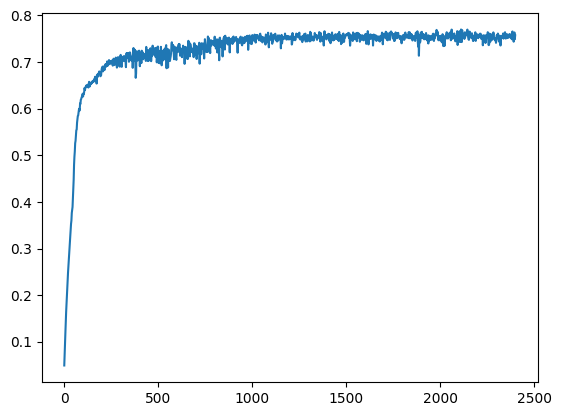

In [13]:
plt.plot(np.arange(0,2*len(np.array(metrics['test_Mean_Dice'])),2),np.array(metrics['test_Mean_Dice']))
print(len(np.array(metrics['test_Mean_Dice'])))


1200


0.7514572739601135

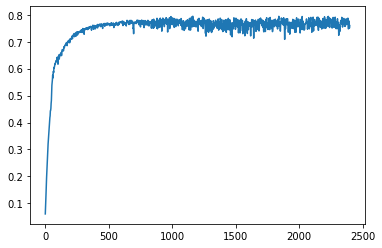

In [9]:
plt.plot(np.arange(0,2*len(np.array(metrics['Val_Mean_Dice'])),2),np.array(metrics['Val_Mean_Dice']))
print(len(np.array(metrics['Val_Mean_Dice'])))
np.array(metrics['test_Mean_Dice'])[np.argmax(np.array(metrics['Val_Mean_Dice']))]

In [6]:
metrics

,Unnamed: 0,Val_Mean_Dice,test_Mean_Dice,boundary_detection_dice,boundary_detection_dice_test,boundary_difference_dice,boundary_difference_dice_test
0,0,0.060866,0.049308,0.169935,0.151415,0.902369,0.913377
1,1,0.083653,0.070942,0.146984,0.149074,0.909967,0.907884
2,2,0.109461,0.094838,0.148729,0.139993,0.905022,0.906143
3,3,0.138054,0.119836,0.150313,0.133482,0.901739,0.913726
4,4,0.168917,0.144837,0.138817,0.169108,0.914040,0.880686
...,...,...,...,...,...,...,...
1195,1195,0.749600,0.743533,0.277142,0.261017,0.916989,0.926492
1196,1196,0.758866,0.755902,0.262445,0.252673,0.932798,0.936688
1197,1197,0.776585,0.763340,0.264518,0.244814,0.931247,0.949272
1198,1198,0.750435,0.748739,0.249626,0.253925,0.953011,0.944175


In [15]:
np.mean(np.array(metrics['test_Mean_Dice'])[-100:])

0.7533194071054459

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.58it/s]


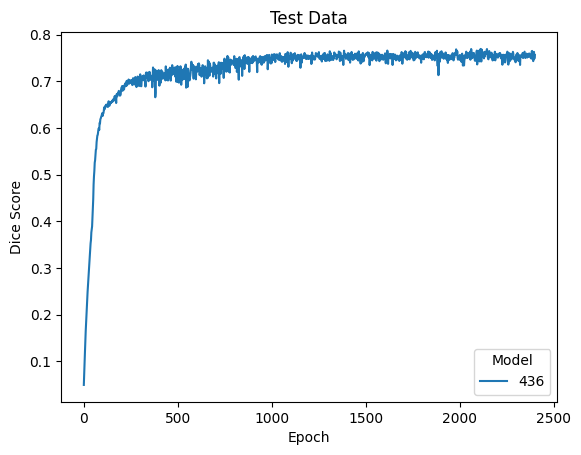

In [7]:
plt.style.use('default')
for file in tqdm(folders[2:3]):
    metrics = pd.read_excel(file)
    plt.plot(np.arange(0,2400,2),
             np.array(metrics['test_Mean_Dice']),
             label = re.sub('training_models/','',re.sub('/metrics_validation_rerun.xlsx','',file)))
plt.legend(title='Model')
plt.xlabel('Epoch')
plt.ylabel('Dice Score')
plt.title('Test Data')
plt.savefig('436_test.png')

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.17it/s]


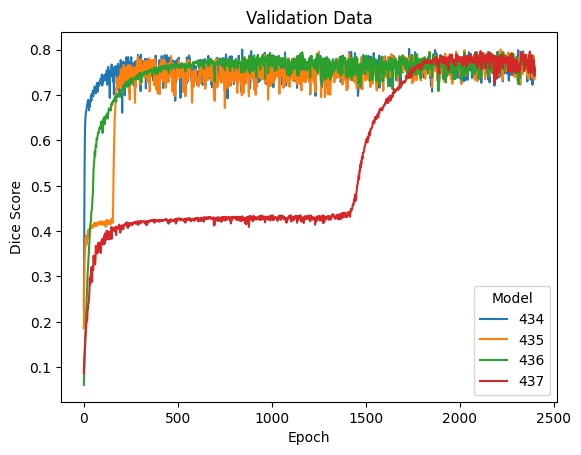

In [8]:
for file in tqdm(folders[:4]):
    metrics = pd.read_excel(file)
    plt.plot(np.arange(0,2400,2),
             np.array(metrics['Val_Mean_Dice']),
             label = re.sub('training_models/','',re.sub('/metrics_validation_rerun.xlsx','',file)))
plt.legend(title='Model')
plt.xlabel('Epoch')
plt.ylabel('Dice Score')
plt.title('Validation Data')
plt.savefig('434-437_val.png')

# Hyperparameter optimization

## UNETR

In [11]:
runs = np.arange(362,434,1)
runs = runs.astype('str')
runs

array(['362', '363', '364', '365', '366', '367', '368', '369', '370',
       '371', '372', '373', '374', '375', '376', '377', '378', '379',
       '380', '381', '382', '383', '384', '385', '386', '387', '388',
       '389', '390', '391', '392', '393', '394', '395', '396', '397',
       '398', '399', '400', '401', '402', '403', '404', '405', '406',
       '407', '408', '409', '410', '411', '412', '413', '414', '415',
       '416', '417', '418', '419', '420', '421', '422', '423', '424',
       '425', '426', '427', '428', '429', '430', '431', '432', '433'],
      dtype='<U21')

In [12]:
dirc = Path('training_models/')
folders = list(dirc.glob('*/metrics_validation.csv'))
folders = sorted([x.as_posix() for x in folders])
folders = [x for x in folders if re.sub('training_models/','',re.sub('/metrics_validation.csv','',x)) in runs]

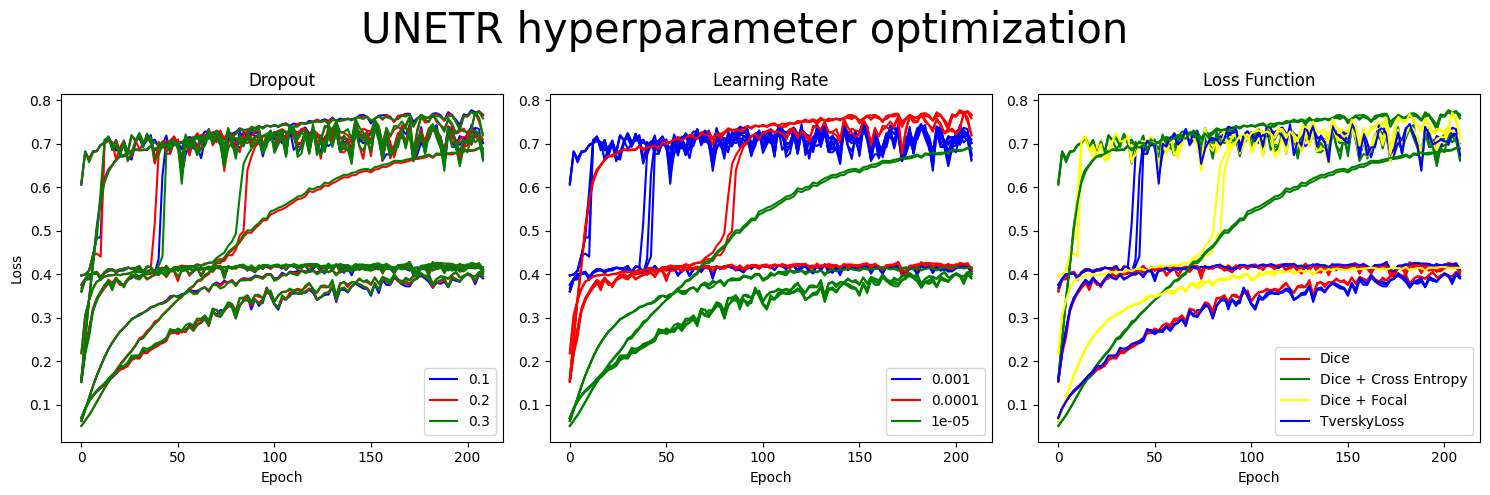

In [13]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(15, 5))
for file in folders:
    parameter_file = 'hyperparameter_pickle_files/parameters' + re.sub('training_models/','',re.sub('/metrics_validation.csv','',file)) + '.pickle'
    with open(parameter_file, 'rb') as handle:
        params = pickle.load(handle)
    if params['norm'] == 'INSTANCE':
        metrics = pd.read_csv(file)
        if params['dropout'] == 0.1:
            ax1.plot(np.arange(0,2*len(np.array(metrics['Val_Mean_Dice'])),2),
                     np.array(metrics['Val_Mean_Dice']),
                     label = params['dropout'],
                     color = 'blue')
        elif params['dropout'] == 0.2:
            ax1.plot(np.arange(0,2*len(np.array(metrics['Val_Mean_Dice'])),2),
                     np.array(metrics['Val_Mean_Dice']),
                     label = params['dropout'],
                     color = 'red')
        elif params['dropout'] == 0.3:
            ax1.plot(np.arange(0,2*len(np.array(metrics['Val_Mean_Dice'])),2),
                     np.array(metrics['Val_Mean_Dice']),
                     label = params['dropout'],
                     color = 'green')
        else:
            break
        if params['learning_rate'] == 1e-3:
            ax2.plot(np.arange(0,2*len(np.array(metrics['Val_Mean_Dice'])),2),
                     np.array(metrics['Val_Mean_Dice']),
                     label = params['learning_rate'],
                     color = 'blue')
        elif params['learning_rate'] == 1e-4:
            ax2.plot(np.arange(0,2*len(np.array(metrics['Val_Mean_Dice'])),2),
                     np.array(metrics['Val_Mean_Dice']),
                     label = params['learning_rate'],
                     color = 'red')
        elif params['learning_rate'] == 1e-5:
            ax2.plot(np.arange(0,2*len(np.array(metrics['Val_Mean_Dice'])),2),
                     np.array(metrics['Val_Mean_Dice']),
                     label = params['learning_rate'],
                     color = 'green')
        else:
            break
        if str(params['loss_function']) == 'TverskyLoss()':
            ax3.plot(np.arange(0,2*len(np.array(metrics['Val_Mean_Dice'])),2),
                     np.array(metrics['Val_Mean_Dice']),
                     label = 'TverskyLoss',
                     color = 'blue')
        elif str(params['loss_function']) == 'DiceLoss()':
            ax3.plot(np.arange(0,2*len(np.array(metrics['Val_Mean_Dice'])),2),
                     np.array(metrics['Val_Mean_Dice']),
                     label = 'Dice',
                     color = 'red')
        elif str(params['loss_function']) == 'DiceCELoss(\n  (dice): DiceLoss()\n  (cross_entropy): CrossEntropyLoss()\n)':
            ax3.plot(np.arange(0,2*len(np.array(metrics['Val_Mean_Dice'])),2),
                     np.array(metrics['Val_Mean_Dice']),
                     label = 'Dice + Cross Entropy',
                     color = 'green')
        elif str(params['loss_function']) == 'DiceFocalLoss(\n  (dice): DiceLoss()\n  (focal): FocalLoss()\n)':
            ax3.plot(np.arange(0,2*len(np.array(metrics['Val_Mean_Dice'])),2),
                     np.array(metrics['Val_Mean_Dice']),
                     label = 'Dice + Focal',
                     color = 'Yellow')
        else:
            break
plt.sca(ax1)
handles, labels = plt.gca().get_legend_handles_labels()
newLabels, newHandles = [], []
for handle, label in zip(handles, labels):
    if label not in newLabels:
        newLabels.append(label)
        newHandles.append(handle)
ax1.legend(newHandles, newLabels)
plt.sca(ax2)
handles, labels = plt.gca().get_legend_handles_labels()
newLabels, newHandles = [], []
for handle, label in zip(handles, labels):
    if label not in newLabels:
        newLabels.append(label)
        newHandles.append(handle)
ax2.legend(newHandles, newLabels)
plt.sca(ax3)
handles, labels = plt.gca().get_legend_handles_labels()
newLabels, newHandles = [], []
for handle, label in zip(handles, labels):
    if label not in newLabels:
        newLabels.append(label)
        newHandles.append(handle)
ax3.legend(newHandles, newLabels)
ax1.set_xlabel('Epoch')
ax2.set_xlabel('Epoch')
ax3.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Dropout')
ax2.set_title('Learning Rate')
ax3.set_title('Loss Function')
fig.suptitle('UNETR hyperparameter optimization', fontsize=30)
fig.tight_layout()
fig.savefig('UNETR_optim_short.png')

## Unet

In [14]:
runs = np.arange(1,362,1)
runs = runs.astype('str')

In [15]:
dirc = Path('training_models/')
folders = list(dirc.glob('*/metrics_validation.csv'))
folders = sorted([x.as_posix() for x in folders])
folders = [x for x in folders if re.sub('training_models/','',re.sub('/metrics_validation.csv','',x)) in runs]

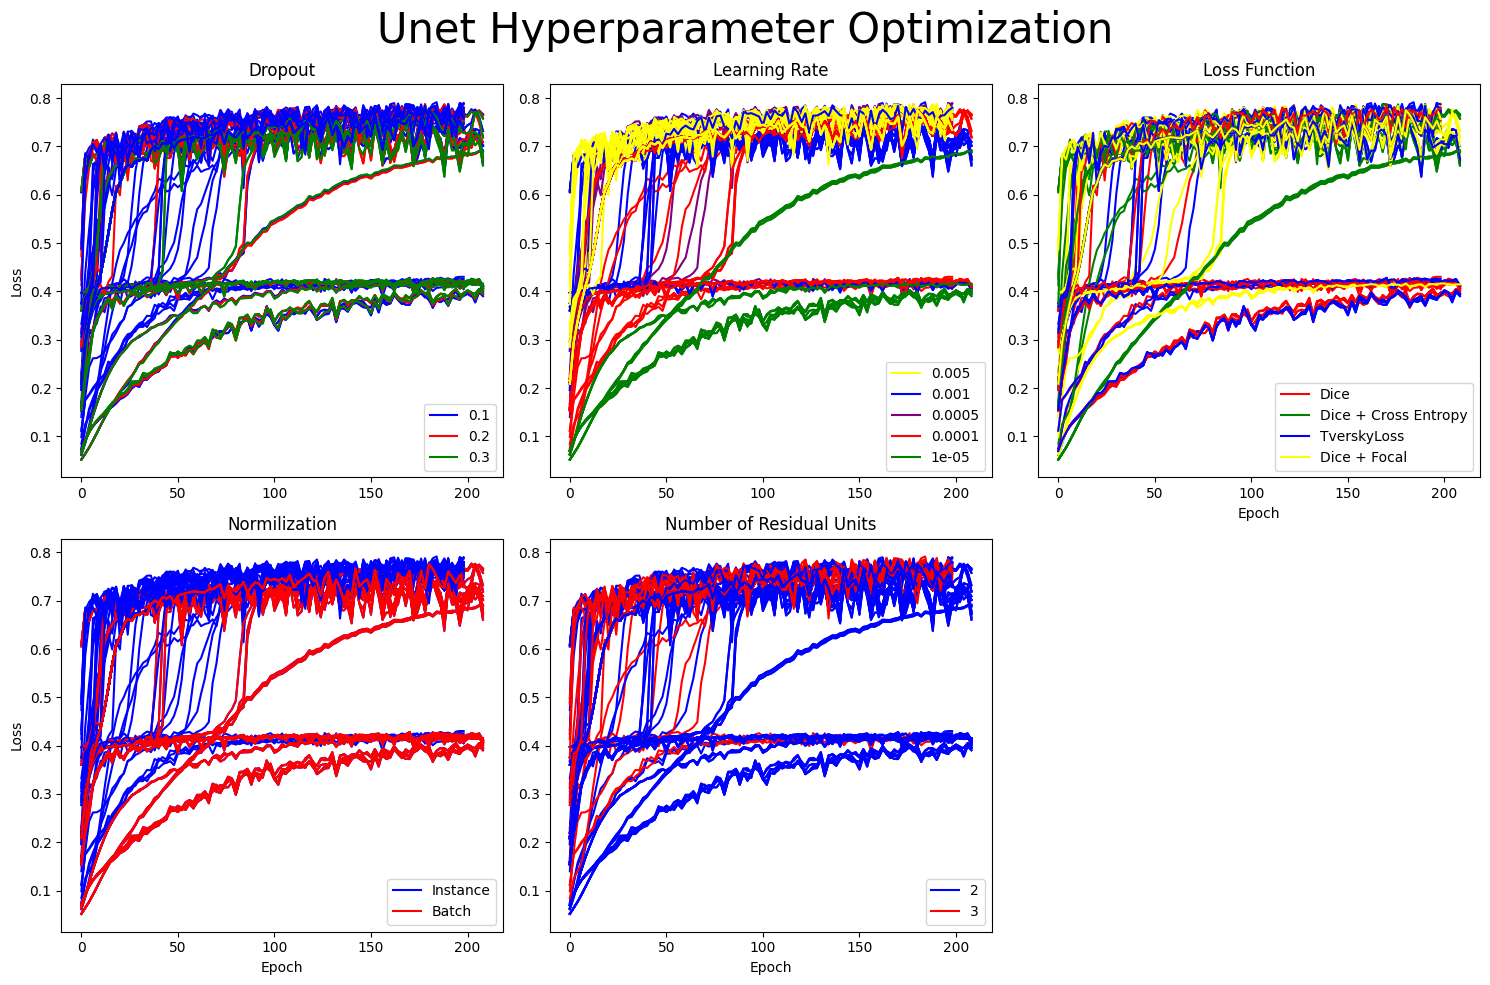

In [16]:
fig, ax = plt.subplots(2,3,figsize=(15, 10))
for file in folders:
    parameter_file = 'hyperparameter_pickle_files/parameters' + re.sub('training_models/','',re.sub('/metrics_validation.csv','',file)) + '.pickle'
    with open(parameter_file, 'rb') as handle:
        params = pickle.load(handle)
    metrics = pd.read_csv(file)
    if 'Val_Mean_Dice' in metrics.keys():
        if params['dropout'] == 0.1:
            ax[0,0].plot(np.arange(0,2*len(np.array(metrics['Val_Mean_Dice'])),2),
                     np.array(metrics['Val_Mean_Dice']),
                     label = params['dropout'],
                     color = 'blue')
        elif params['dropout'] == 0.2:
            ax[0,0].plot(np.arange(0,2*len(np.array(metrics['Val_Mean_Dice'])),2),
                     np.array(metrics['Val_Mean_Dice']),
                     label = params['dropout'],
                     color = 'red')
        elif params['dropout'] == 0.3:
            ax[0,0].plot(np.arange(0,2*len(np.array(metrics['Val_Mean_Dice'])),2),
                     np.array(metrics['Val_Mean_Dice']),
                     label = params['dropout'],
                     color = 'green')
        else:
            print(params['dropout'])
            break
        if params['learning_rate'] == 1e-3:
            ax[0,1].plot(np.arange(0,2*len(np.array(metrics['Val_Mean_Dice'])),2),
                     np.array(metrics['Val_Mean_Dice']),
                     label = params['learning_rate'],
                     color = 'blue')
        elif params['learning_rate'] == 1e-4:
            ax[0,1].plot(np.arange(0,2*len(np.array(metrics['Val_Mean_Dice'])),2),
                     np.array(metrics['Val_Mean_Dice']),
                     label = params['learning_rate'],
                     color = 'red')
        elif params['learning_rate'] == 5e-4:
            ax[0,1].plot(np.arange(0,2*len(np.array(metrics['Val_Mean_Dice'])),2),
                     np.array(metrics['Val_Mean_Dice']),
                     label = params['learning_rate'],
                     color = 'purple')
        elif params['learning_rate'] == 5e-3:
            ax[0,1].plot(np.arange(0,2*len(np.array(metrics['Val_Mean_Dice'])),2),
                     np.array(metrics['Val_Mean_Dice']),
                     label = params['learning_rate'],
                     color = 'yellow')
        elif params['learning_rate'] == 1e-5:
            ax[0,1].plot(np.arange(0,2*len(np.array(metrics['Val_Mean_Dice'])),2),
                     np.array(metrics['Val_Mean_Dice']),
                     label = params['learning_rate'],
                     color = 'green')
        else:
            print(params['learning_rate'])
            break
        if str(params['loss_function']) == 'TverskyLoss()':
            ax[0,2].plot(np.arange(0,2*len(np.array(metrics['Val_Mean_Dice'])),2),
                     np.array(metrics['Val_Mean_Dice']),
                     label = 'TverskyLoss',
                     color = 'blue')
        elif str(params['loss_function']) == 'DiceLoss()':
            ax[0,2].plot(np.arange(0,2*len(np.array(metrics['Val_Mean_Dice'])),2),
                     np.array(metrics['Val_Mean_Dice']),
                     label = 'Dice',
                     color = 'red')
        elif str(params['loss_function']) == 'DiceCELoss(\n  (dice): DiceLoss()\n  (cross_entropy): CrossEntropyLoss()\n)':
            ax[0,2].plot(np.arange(0,2*len(np.array(metrics['Val_Mean_Dice'])),2),
                     np.array(metrics['Val_Mean_Dice']),
                     label = 'Dice + Cross Entropy',
                     color = 'green')
        elif str(params['loss_function']) == 'DiceFocalLoss(\n  (dice): DiceLoss()\n  (focal): FocalLoss()\n)':
            ax[0,2].plot(np.arange(0,2*len(np.array(metrics['Val_Mean_Dice'])),2),
                     np.array(metrics['Val_Mean_Dice']),
                     label = 'Dice + Focal',
                     color = 'Yellow')
        else:
            print(str(params['loss_function']))
            break
        if str(params['norm']) == 'INSTANCE':
            ax[1,0].plot(np.arange(0,2*len(np.array(metrics['Val_Mean_Dice'])),2),
                     np.array(metrics['Val_Mean_Dice']),
                     label = 'Instance',
                     color = 'blue')
        elif str(params['norm']) == 'BATCH':
            ax[1,0].plot(np.arange(0,2*len(np.array(metrics['Val_Mean_Dice'])),2),
                     np.array(metrics['Val_Mean_Dice']),
                     label = 'Batch',
                     color = 'red')
        else:
            print(params['norm'])
            break
        if params['num_res_units'] == 2:
            ax[1,1].plot(np.arange(0,2*len(np.array(metrics['Val_Mean_Dice'])),2),
                     np.array(metrics['Val_Mean_Dice']),
                     label = 2,
                     color = 'blue')
        elif params['num_res_units'] == 3:
            ax[1,1].plot(np.arange(0,2*len(np.array(metrics['Val_Mean_Dice'])),2),
                     np.array(metrics['Val_Mean_Dice']),
                     label = 3,
                     color = 'red')
        else:
            print(params['num_res_units'])
            break
plt.sca(ax[0,0])
handles, labels = plt.gca().get_legend_handles_labels()
newLabels, newHandles = [], []
for handle, label in zip(handles, labels):
    if label not in newLabels:
        newLabels.append(label)
        newHandles.append(handle)
ax[0,0].legend(newHandles, newLabels)
plt.sca(ax[0,1])
handles, labels = plt.gca().get_legend_handles_labels()
newLabels, newHandles = [], []
for handle, label in zip(handles, labels):
    if label not in newLabels:
        newLabels.append(label)
        newHandles.append(handle)
ax[0,1].legend(newHandles, newLabels)
plt.sca(ax[0,2])
handles, labels = plt.gca().get_legend_handles_labels()
newLabels, newHandles = [], []
for handle, label in zip(handles, labels):
    if label not in newLabels:
        newLabels.append(label)
        newHandles.append(handle)
ax[0,2].legend(newHandles, newLabels)
plt.sca(ax[1,0])
handles, labels = plt.gca().get_legend_handles_labels()
newLabels, newHandles = [], []
for handle, label in zip(handles, labels):
    if label not in newLabels:
        newLabels.append(label)
        newHandles.append(handle)
ax[1,0].legend(newHandles, newLabels)
plt.sca(ax[1,1])
handles, labels = plt.gca().get_legend_handles_labels()
newLabels, newHandles = [], []
for handle, label in zip(handles, labels):
    if label not in newLabels:
        newLabels.append(label)
        newHandles.append(handle)
ax[1,1].legend(newHandles, newLabels)

ax[1,0].set_xlabel('Epoch')
ax[1,1].set_xlabel('Epoch')
ax[0,2].set_xlabel('Epoch')
ax[0,0].set_ylabel('Loss')
ax[1,0].set_ylabel('Loss')
ax[0,0].set_title('Dropout')
ax[0,1].set_title('Learning Rate')
ax[0,2].set_title('Loss Function')
ax[1,0].set_title('Normilization')
ax[1,1].set_title('Number of Residual Units')
fig.delaxes(ax[1,2])
fig.suptitle('Unet Hyperparameter Optimization', fontsize=30)
fig.tight_layout()
fig.savefig('unet_optim_short.png')

In [17]:
'Val_Mean_Dice' in metrics.keys()

True

In [18]:
metrics.keys()

Index(['Unnamed: 0', 'Val_Mean_Dice', 'boundary_detection_dice',
       'boundary_difference_dice'],
      dtype='object')